# Dynamic instability in Self-assembly

## Preview of Updation
1. Finish the evolution part evolve(); I use _try_attach/_try_detach to construct the last chain, when it is all occupied/or empty, it is attached/detached from the assmebly
2. I think we should sepicify the directions in the interaction matrix so I changed J matrix to J_NS and J_WE, which corresponds to the vertical and horizontal dirsction respectively


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from tqdm.notebook import tqdm_notebook
from matplotlib.colors import BoundaryNorm


# Customization of the figures parameters
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams["savefig.format"] = "png"
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["figure.figsize"] = (12.8, 7.2)

## Issues
1. Something I am not sure: inside class Assembly, I comment the line 33, since I thought it depends on the order (e.x. from top-to-down direction, tile 1 is bonded with tile 2, but not the opposite way, that's why we have the order 1-2-3-4...  // but for the horizontal direction, it seems like both way is bonded (e.x. 1-7-1, 2-8-2, etc.
2. I don't know what kf they are using in the paper,so I fail to benchmark it

In [46]:
class Assembly:
    """
    Class for representing the assembmly.

    It is represented as an array of size (6, N), accessible with self.chain.
    The elements are integers from 0 to 12, where 0 means empty, and 1 to 12 a tile of corresponding number.
    """

    # TODO: add the possibility to add only one tile, and keep track of empty in last line.
    # Idea for that: check nb of bonds on each of the 6 accessible sites, attach at random, with higher proba if more bonds.
    def __init__(self, cross, nonSpec):
        """
        Creates the assembly, and the interaction matrix.

        cross: gives which interactions are taken into account. See p40.
               0, 1, 2 correspond to the small, medium, large barrier respectively.
               
        nonSpec: consider the nonsecific interations or not.

        """
        if cross not in (0, 1, 2):
            raise ValueError(f"The parameter must be equal to 0, 1 or 2 (and not {cross}).")

        J_NS = np.zeros((13, 13))  # Construction of interaction martix, north-south
        J_WE = np.zeros((13, 13))  # Construction of interaction martix, western-east
        for i in range(13):
            for j in range(13):
                # Interactions for all barriers
                if j == 0 or i == 0:  # 0 means empty, so it does not interact with anything
                    continue
                if j == i+1:
                    J_NS[i, j] = 1
#                     J_NS[j, i] = 1  # Makes the matrix symmetric

                elif nonSpec == True and (i, j) in [(1, 5), (5, 4), (4, 3), (3, 2), (2, 6)]: 
                    J_NS[i, j] = 1

                elif j == i+6:  # The paper indicates i+5, but I think it is i+6 (e.g. 2 should link with 8, and not 7).
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1

                # Interactions that depend on the barrier
                if cross == 0 and (i-1, j-1) in [(5, 8), (4, 9)]:
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1
                elif cross == 1 and (i-1, j-1) in [(5, 8), (3, 10)]:
                    J_WE[i, j] = 1
                    J_WE[j, i] = 1

        self.chain = np.array([[1, 2, 3, 4, 5, 6]], dtype=int)  # Tile assembly
        self.lastchain = np.zeros(6, dtype = int) # initialize the last chain
        self.inter_NS = J_NS  # Interaction matrix
        self.inter_WE = J_WE  # Interaction matrix

    def add_line(self, line):
        """
        Adds a new line to the assembly.

        The inputs are the assembly, and an array or a list of size 6 to append to the assembly.
        """
        line = np.array(line, dtype=int)
        # Checks that the new line has the right format
        if not all([elem >= 0 and elem <= 12 for elem in line]):
            raise ValueError(f"Invalid elements in added line: {line}.")
        if len(line) != 6:
            raise ValueError(f"The added line {line} must be of length 6 (and not {len(line)}).")

        self.chain = np.block([[self.chain], [line]])

    def remove_line(self):
        """Removes the last line of the assembly."""
        self.chain = self.chain[:-1, :]

    def energy(self):
        """Returns the energy of the assembly."""
        e = 0
        a, b = self.chain.shape

        # This adds 0 below and on the right of the assembly matrix.
        # They will give no interaction with the rest of the assembly
        # but allow to handle the boundaries more easily
        low = np.zeros(a+1, dtype=int)
        right = np.zeros(b, dtype=int)
        A2 = np.block([[self.chain], [right]])
        A = np.column_stack([A2, low])

        # Computation of the energy
        for i in range(a):  # Loops on the shape of the original assembly
            for j in range(b):
                # A has a shape of a+1, b+1, so no out-of-index errors
                val = A[i, j]  # Type of the block at i, j
                val_b = A[i+1, j]  # Value of the block below (or to the right in the article's figures)
                val_r = A[i, j+1]  # Value right (or below in the figure)
                e += self.inter_WE[val, val_r]  # Interaction on the right
                e += self.inter_NS[val, val_b]  # Interaction below
        return e
    
    def evolve_new(self, Nstep, Gmc, Gse, kf, cycles=None):
        """
        Simulates the growth of an assembly using the kTAM model.

        Nstep: Number of steps (attachment or detachment)
        Gmc: Free energy for monomer concentration (controls attachment rate)
        Gse: Free energy of binding for each bond (controls detachment rate) in grow, melt states
        kf: Frequency factor for attachment and detachment rates
        cycles: Melting time, cycle time (in steps). If None, melting time is 0

        Returns:
            - The energy at each step
            - A record of the assembly states at each step for visualization
        """
        E = np.zeros(Nstep)  # Energy at each step
        assembly_snapshots = []  # Store snapshots of the assembly for visualization later
        if cycles is None:  # Same syntax as before if cycles are not studied.
            cycles = (0, 3600)
            Gse = (Gse, Gse)
            
        pbar = tqdm_notebook(np.arange(Nstep), miniters=Nstep // 100)  # Update every 1% of Nstep
        for n, step in enumerate(pbar):
            if n % cycles[1] <= cycles[0]:  # Melting state: weak bonds
                Gse_step = Gse[1]
            else:  # Growing state: strong bonds
                Gse_step = Gse[0]
                
            # compute Z
            Z = 0
            occupied_positions = np.argwhere(self.lastchain != 0)
            empty_positions = np.argwhere(self.lastchain == 0)
            p = [] # caculate np.exp(-bonds * Gse_step)
            for occupied_index in occupied_positions:
                tile_now = self.lastchain[occupied_index]
                bond_now = self._count_bonds(occupied_index, tile_now)
                p.append(np.exp(-bond_now * Gse_step))
                Z += np.exp(-bond_now * Gse_step)
                
            Z += (6 - len(occupied_positions)) * np.exp(-Gmc)
            pro_add = (6 - len(occupied_positions)) * np.exp(-Gmc) / Z 
#             print(len(occupied_positions),pro_add)
            
            if np.random.rand() < pro_add: # we should add tiles
#                 i = empty_positions[np.random.randint(len(empty_positions))]
                for j in empty_positions:
                    self.lastchain[j] = np.random.randint(1,13)
            else: # remove a tile
                seed_now = np.random.rand()
                p = np.array(p) / np.sum(p)
                for j,occupied_index in enumerate(occupied_positions):
                    if(seed_now < np.sum(p[:(j+1)])):
                        self.lastchain[occupied_index] = 0
                        break
            
            
            
#             if np.random.rand() < pro_add: # we should a add tile
#                 i = empty_positions[np.random.randint(len(empty_positions))]
#                 self.lastchain[i] = np.random.randint(1,13)
#             else: # remove a tile
#                 seed_now = np.random.rand()
#                 p = np.array(p) / np.sum(p)
#                 for j,occupied_index in enumerate(occupied_positions):
#                     if(seed_now < np.sum(p[:(j+1)])):
#                         self.lastchain[occupied_index] = 0
#                         break           

            if np.all(self.lastchain) != 0:  # if the last chain is occuied, add it to the assembly
                self.add_line(self.lastchain)
                self.lastchain = np.zeros(6, dtype=int)  # reset the last chain

            elif np.sum(self.lastchain) == 0 and len(self.chain) > 1:
                self.lastchain = self.chain[-1, :].reshape(-1)
                self.remove_line()

            E[n] = self.energy()  # Recompute energy after each step
            if n % 100 == 0:  # Store one snapshot every 100 steps to not take too much resources ?
                assembly_snapshots.append(self.chain.copy())  # Save the assembly state

        self.add_line(self.lastchain)

        return E, assembly_snapshots

    def evolve(self, Nstep, Gmc, Gse, kf):
        """
        Simulates the growth of an assembly using the kTAM model.
        
        Nstep: Number of steps (attachment or detachment)
        Gmc: Free energy for monomer concentration (controls attachment rate)
        Gse: Free energy of binding for each bond (controls detachment rate)
        kf: Frequency factor for attachment and detachment rates
        
        Returns:
            - The energy at each step
            - A record of the assembly states at each step for visualization
        """
        E = np.zeros(Nstep)  # Energy at each step
        assembly_snapshots = []  # Store snapshots of the assembly for visualization later

        pbar = tqdm_notebook(np.arange(Nstep), miniters=Nstep // 100)  # Update every 1% of Nstep
        for n, step in enumerate(pbar):
#             pbar.set_description(f"Processing:step={step:.0f}")
            if np.random.rand() < 0.5:  # Randomly choose attachment or detachment step (50% chance)
                self._try_attach(Gmc, kf)  # Attempt to attach a tile
            else:
                self._try_detach(Gse, kf)  # Attempt to detach a tile

            if np.all(self.lastchain) != 0: #if the last chain is occuied, add it to the assembly
                self.add_line(self.lastchain)
                self.lastchain = np.zeros(6, dtype = int) #reset the last chain
                
            elif np.sum(self.lastchain) == 0 and len(self.chain)>1:
                self.lastchain = self.chain[-1,:].reshape(-1)
                self.remove_line()
                
            E[n] = self.energy()  # Recompute energy after each step
            assembly_snapshots.append(self.chain.copy())  # Save the assembly state
        
        self.add_line(self.lastchain)

        return E, assembly_snapshots

    def _try_attach(self, Gmc, kf):
        """
        Attempt to attach a tile at a random empty position in the assembly.
        The attachment rate depends on the number of bonds the tile can form.
        """
        # Find empty positions (where lastchain == 0)
        empty_positions = np.argwhere(self.lastchain == 0)

        if len(empty_positions) == 0:
            return  # No empty positions to attach a tile

        # Randomly pick an empty position
        i = empty_positions[np.random.randint(len(empty_positions))]

        # Try attaching a random tile (between 1 and 12)
        tile = np.random.randint(1, 13)

        # Calculate the number of bonds the tile would form
        bonds = self._count_bonds(i, tile)

        # Attachment rate based on Gmc and bonds
        ron = kf * np.exp(-Gmc)

        if np.random.rand() < ron:
            self.lastchain[i] = tile  # Attach the tile

    def _try_detach(self, Gse, kf):
        """
        Attempt to detach a tile from a random occupied position in the assembly.
        The detachment rate depends on the number of bonds the tile has.
        """
        # Find occupied positions (where chain != 0)
        occupied_positions = np.argwhere(self.lastchain != 0)

        if len(occupied_positions) == 0:
            return  # No occupied positions to detach a tile

        # Randomly pick an occupied position
        i = occupied_positions[np.random.randint(len(occupied_positions))]

        tile = self.lastchain[i]

        # Calculate the number of bonds the tile has
        bonds = self._count_bonds(i, tile)

        # Detachment rate based on Gse and number of bonds
        roff_b = kf * np.exp(-bonds * Gse)

        if np.random.rand() < roff_b:
            self.lastchain[i] = 0  # Detach the tile

    def _count_bonds(self, i, tile):
        """
        Count the number of bonds a tile at position i would form with its neighbors.
        """
        bonds = 0
        
        if 0 <= i-1 < self.lastchain.shape: #check the boundary
            neighbors_tile_NS_Up = self.lastchain[i-1]  # Top neighbors
            bonds += self.inter_NS[neighbors_tile_NS_Up,tile]
        if 0 <= i+1 < self.lastchain.shape:
            neighbors_tile_NS_Down = self.lastchain[i+1] # Bottom neibors
            bonds += self.inter_NS[tile,neighbors_tile_NS_Down]
 
        neighbor_tile_WE = self.chain[-1,i] #Check the left neighbor
        bonds += self.inter_WE[neighbor_tile_WE,tile]  # Add interaction if there's a bond
                
        return bonds

    def disorder(self):
        """Returns the proportion of disordered rows."""
        count = 0
        for line in self.chain:
            if (any(line != np.array([1, 2, 3, 4, 5, 6], dtype=int))
                    and any(line != np.array([7, 8, 9, 10, 11, 12], dtype=int))):
                count += 1
        return count/len(self.chain)


In [10]:
def plot_energy(Nstep, cross, nonSpec, Gmc, Gse, kf):
    """Plot the energy as a function of the step."""
    A = Assembly(cross, nonSpec)
    E,_ = A.evolve(Nstep, Gmc, Gse, kf)
    fig, ax = plt.subplots()
    ax.plot(E)
    ax.set(title="Energy of the assembly", xlabel="Step", ylabel="Energy")
    plt.show()

def plot_assembly(Nstep, cross, nonSpec, Gmc, Gse, kf):
    """Plot the assembly with a colormap."""
    A = Assembly(cross, nonSpec)
    A.evolve(Nstep, Gmc, Gse, kf)
    print(A.chain)

    cmap = mpl.colormaps.get_cmap("viridis")
    cmap.set_under("w")  # Sets the 0 values to white color.
    ticks = np.arange(1, 13)  # Renormalize to [1, 12], so 0 are below the min
    norm = BoundaryNorm(ticks, cmap.N)  # Renormalize and discretize the colormap
    fig, ax = plt.subplots()
    img = ax.pcolor(A.chain.T, cmap=cmap, norm=norm)  # Transposed, so that it is plotted like in the paper.
    fig.colorbar(img, ticks=ticks, norm=norm)
    ax.set(title="Assembly", xlabel="Line", ylabel="Column")
    plt.show()

## First Try: just sepcific interactions
This should return ordered configurations

  0%|          | 0/1000 [00:00<?, ?it/s]

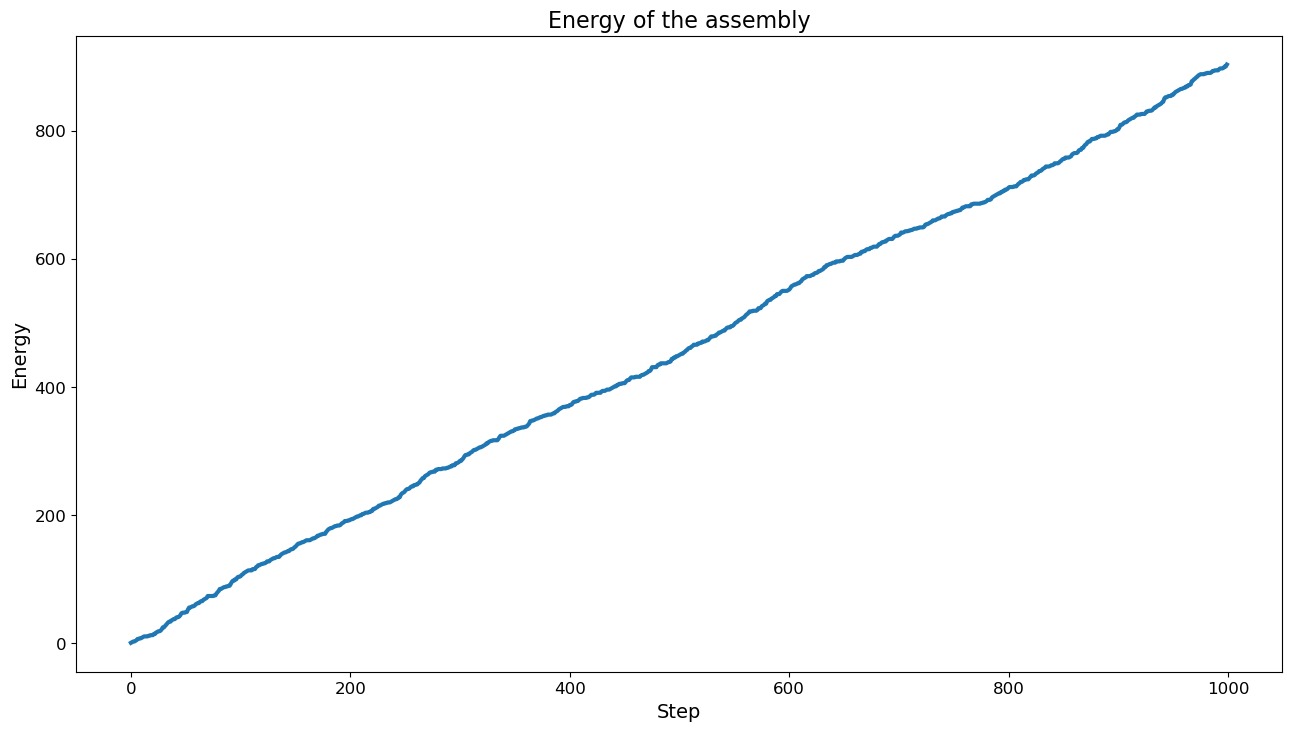

In [50]:
Nstep=10**3
cross=2
nonSpec=False
Gmc=16
Gse=(9.5, 8.4)
kf=7*10**6
cycles=(200, 3600)
# Nstep=10**6
# cross=2
# nonSpec=False
# Gmc=16
# Gse=9.4
# # kf=5*10**6
# kf = 0.8*1/(np.exp(-Gmc))

A = Assembly(cross, nonSpec)
E,snapshots = A.evolve_new(Nstep, Gmc, Gse, kf, cycles)
fig, ax = plt.subplots()
ax.plot(E)
ax.set(title="Energy of the assembly", xlabel="Step", ylabel="Energy")
plt.show()

# Plot the energy evolution
# plot_energy(Nstep=10**5, cross=2, nonSpec = False, Gmc=16, Gse=9.5, kf=8*10**6)

# Plot the assembly configuration after evolution
# plot_assembly(Nstep=10**6, cross=2, nonSpec = False, Gmc=16, Gse=9.5, kf=5*10**6)

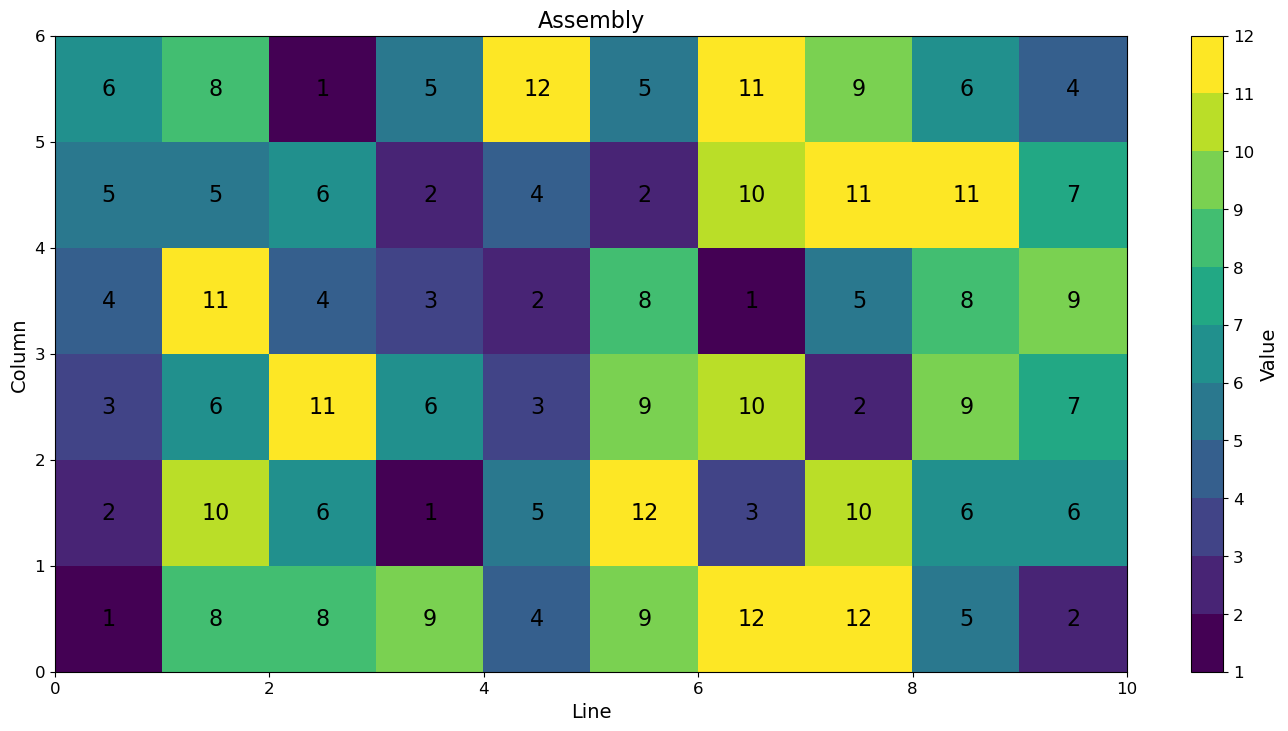

In [51]:
# Set up the colormap and normalization
cmap = mpl.colormaps.get_cmap("viridis")
cmap.set_under("w")  # Sets the 0 values to white color.
ticks = np.arange(1, 13)  # Renormalize to [1, 12], so 0 are below the min
norm = BoundaryNorm(ticks, cmap.N)  # Renormalize and discretize the colormap

# Create the figure and axis
fig, ax = plt.subplots()

# Create the pcolor plot
img = ax.pcolor(A.chain.T[:,:10], cmap=cmap, norm=norm)  # Transposed for correct orientation

# Add the colorbar
cbar = fig.colorbar(img, ticks=ticks, norm=norm)
cbar.set_label('Value')  # Optional label for the colorbar

# Annotate each cell with its value
for (i, j), value in np.ndenumerate(A.chain.T[:,:10]):
    ax.text(j + 0.5, i + 0.5, f'{value}', ha='center', va='center', color='black')

# Set titles and labels
ax.set(title="Assembly", xlabel="Line", ylabel="Column")

# Show the plot
plt.show()

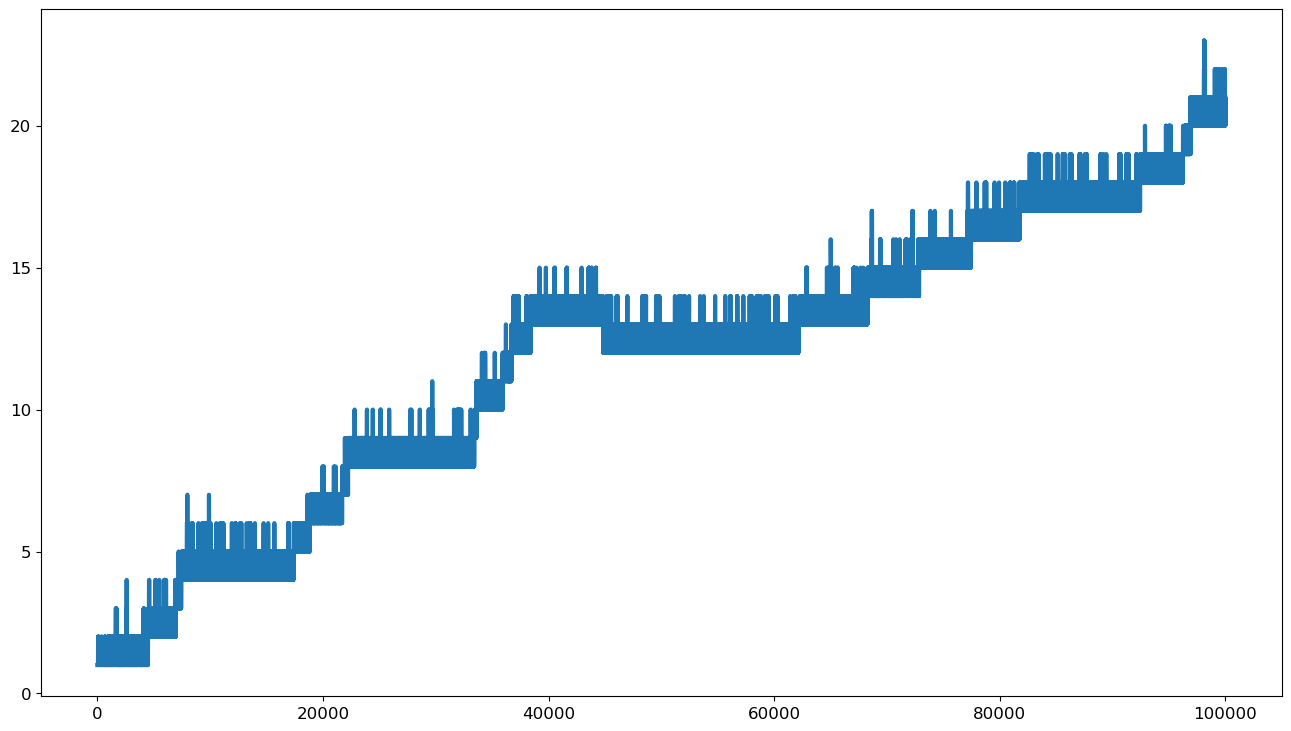

In [70]:
num_tile = []
for i, row in enumerate(snapshots):
    num_tile.append(len(row))
    
fig, ax = plt.subplots()
ax.plot(np.arange(Nstep),num_tile)

## Stalling: Including non-specific interactions

  0%|          | 0/100000 [00:00<?, ?it/s]

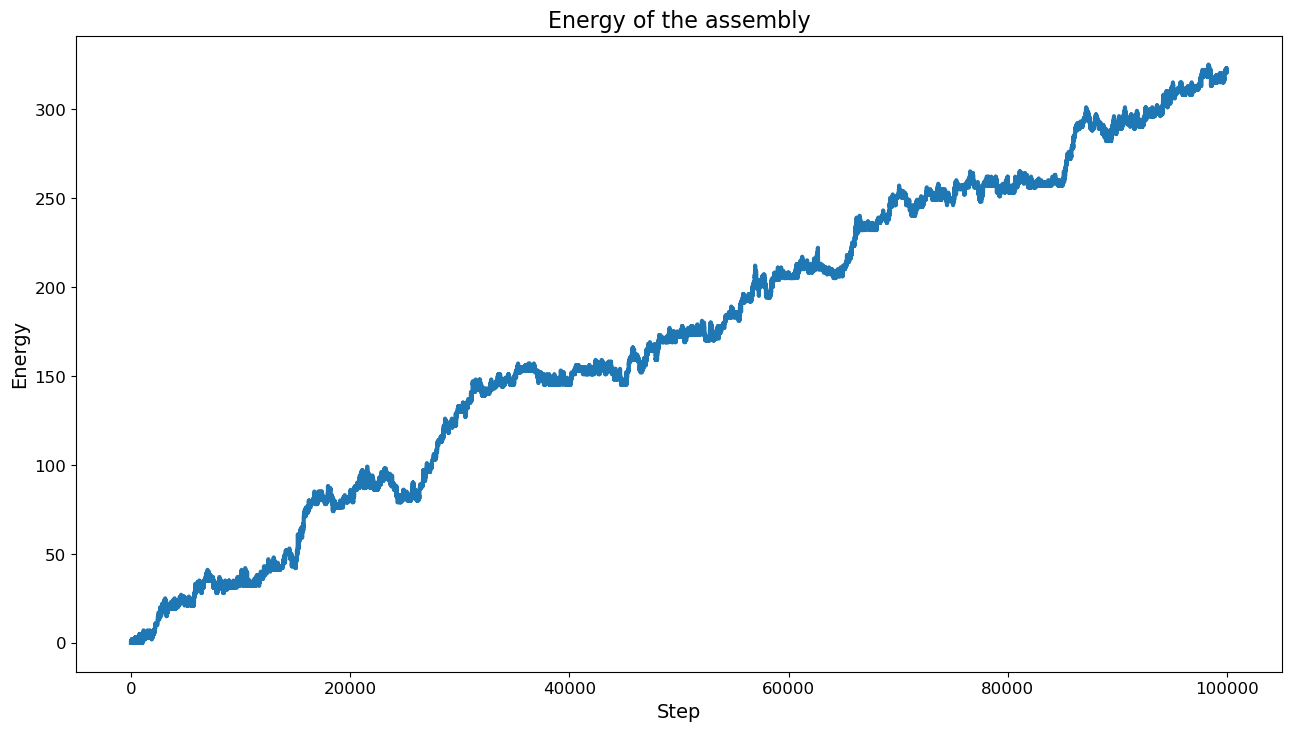

In [42]:
Nstep=10**5
cross=1
nonSpec=True
Gmc=16
Gse=9.4
kf=10**7

A = Assembly(cross, nonSpec)
E,snapshots = A.evolve(Nstep, Gmc, Gse, kf)
fig, ax = plt.subplots()
ax.plot(E)
ax.set(title="Energy of the assembly", xlabel="Step", ylabel="Energy")
plt.show()

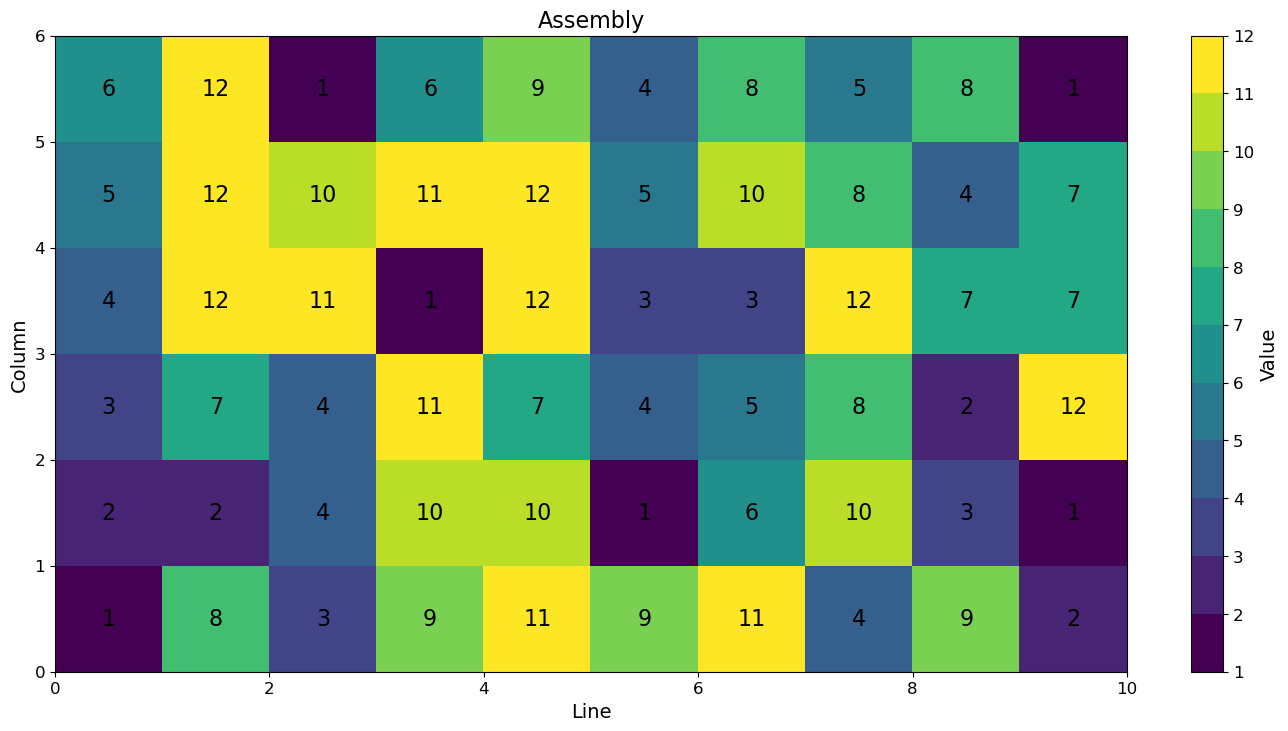

In [46]:
# Set up the colormap and normalization
cmap = mpl.colormaps.get_cmap("viridis")
cmap.set_under("w")  # Sets the 0 values to white color.
ticks = np.arange(1, 13)  # Renormalize to [1, 12], so 0 are below the min
norm = BoundaryNorm(ticks, cmap.N)  # Renormalize and discretize the colormap

# Create the figure and axis
fig, ax = plt.subplots()

# Create the pcolor plot
img = ax.pcolor(A.chain.T[:,:10], cmap=cmap, norm=norm)  # Transposed for correct orientation

# Add the colorbar
cbar = fig.colorbar(img, ticks=ticks, norm=norm)
cbar.set_label('Value')  # Optional label for the colorbar

# Annotate each cell with its value
for (i, j), value in np.ndenumerate(A.chain.T[:,:10]):
    ax.text(j + 0.5, i + 0.5, f'{value}', ha='center', va='center', color='black')

# Set titles and labels
ax.set(title="Assembly", xlabel="Line", ylabel="Column")

# Show the plot
plt.show()

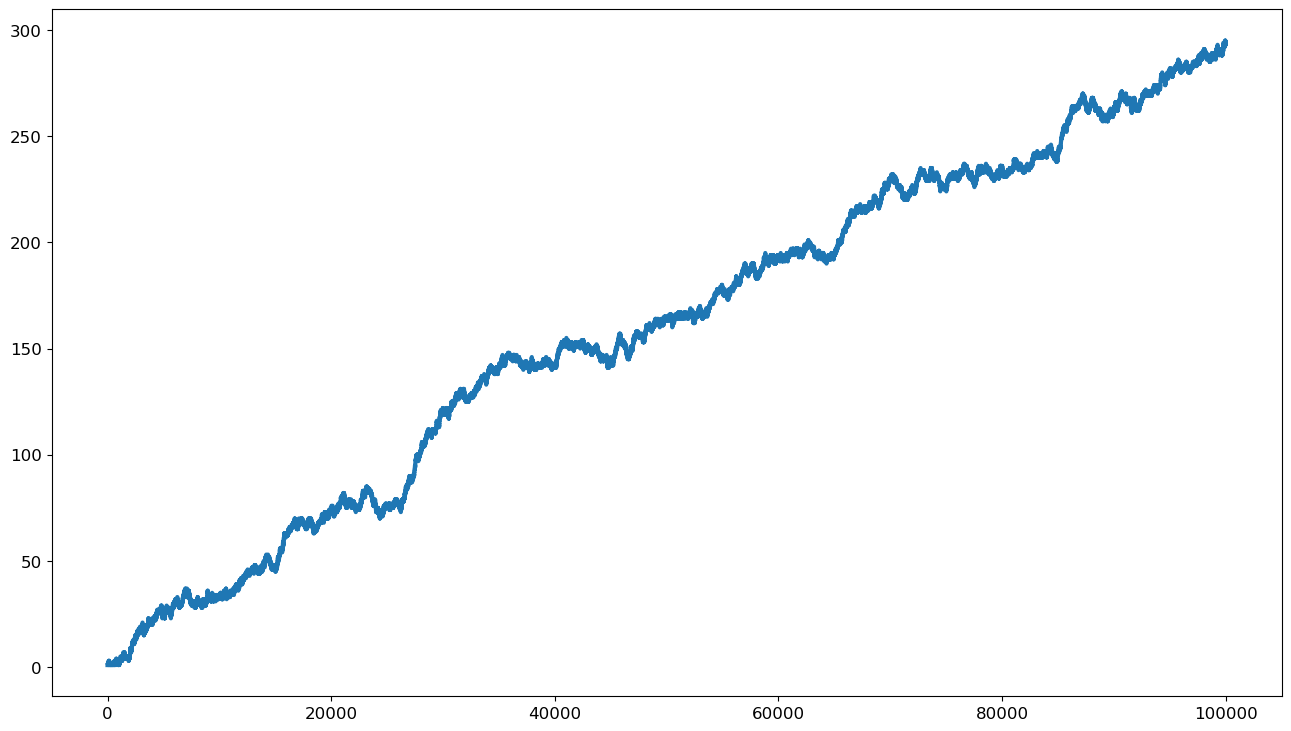

In [47]:
num_tile = []
for i, row in enumerate(snapshots):
    num_tile.append(len(row))
fig, ax = plt.subplots()    
ax.plot(np.arange(Nstep),num_tile)

## Todo
implement the t_melt and t_cycle for simulations (p29,2.4)

In [11]:
print(np.exp(-16),np.exp(-8.4*2))

1.1253517471925912e-07 5.05653134833552e-08
